# DSCI 575: Advanced Machine Learning (in the context of Natural Language Processing (NLP) applications)

## Lecture 2: Using word embeddings

UBC Master of Data Science program, 2019-20

Instructor: Varada Kolhatkar [ʋəɾəda kɔːlɦəʈkər]

### Lecture plan 

- Evaluating quality of word vectors (Video Lecture 2.1)
- Using word embeddings for text classification (Video Lecture 2.1)
- Using word2vec for product recommendation (Video Lecture 2.2)
- Basic text preprocessing (Video Lecture 2.3)

In [6]:
# Thanks to Firas for the following code for making jupyter RISE slides pretty! 
from traitlets.config.manager import BaseJSONConfigManager
from pathlib import Path
path = Path.home() / ".jupyter" / "nbconfig"
cm = BaseJSONConfigManager(config_dir=str(path))
tmp = cm.update(
        "rise",
        {
            "theme": "serif",
            "transition": "fade",
            "start_slideshow_at": "selected",            
            "width": "100%",
            "height": "100%",
            "header": "",
            "footer":"",
            "scroll": True,
            "enable_chalkboard": True,
            "slideNumber": True,
            "center": False,
            "controlsLayout": "edges",
            "slideNumber": True,
            "hash": True,
        }
    )


In [7]:
%%HTML
<style>
.rendered_html table, .rendered_html th, .rendered_html tr, .rendered_html td {
     font-size: 130%;
}

body.rise-enabled div.inner_cell>div.input_area {
    font-size: 100%;
}

body.rise-enabled div.output_subarea.output_text.output_result {
    font-size: 100%;
}
body.rise-enabled div.output_subarea.output_text.output_stream.output_stdout {
  font-size: 150%;
}
</style>

In [8]:
import pandas as pd
import numpy as np
import os, sys
from IPython.display import display, HTML

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer


import nltk
import string
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

from gensim.models import Word2Vec,FastText
import time

import re
from collections import defaultdict
from collections import Counter


###  Learning outcomes

By the end of this class you will be able to 

- Explain how could we evaluate quality of word embeddings 
- Use word embeddings in text classification  
- Use the word2vec algorithm to build product recommendation system
- Carry out basic text preprocessing using `nltk` and `spaCy`

### Evaluating quality of word vectors

### t-SNE projection of embeddings of some words

In [6]:
# Load GoogleNews pretrained embeddings
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format('/Users/kvarada/MDS/2019-20/575/data/GoogleNews-vectors-negative300.bin', binary=True)

In [11]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    #colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    colors = ['red', 'green', 'blue', 'cyan', 'orange']
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=2.0, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=12)
    plt.legend(loc=2)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()

In [12]:
keys = ['Vancouver', 'data', 'mango', 'hockey', 'meditation']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in model.most_similar(word, topn=10):
        words.append(similar_word)
        embeddings.append(model[similar_word])
        
    embedding_clusters.append(embeddings)
    word_clusters.append(words)
    
from sklearn.manifold import TSNE
import numpy as np

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)    

import matplotlib.pyplot as plt
import matplotlib.cm as cm

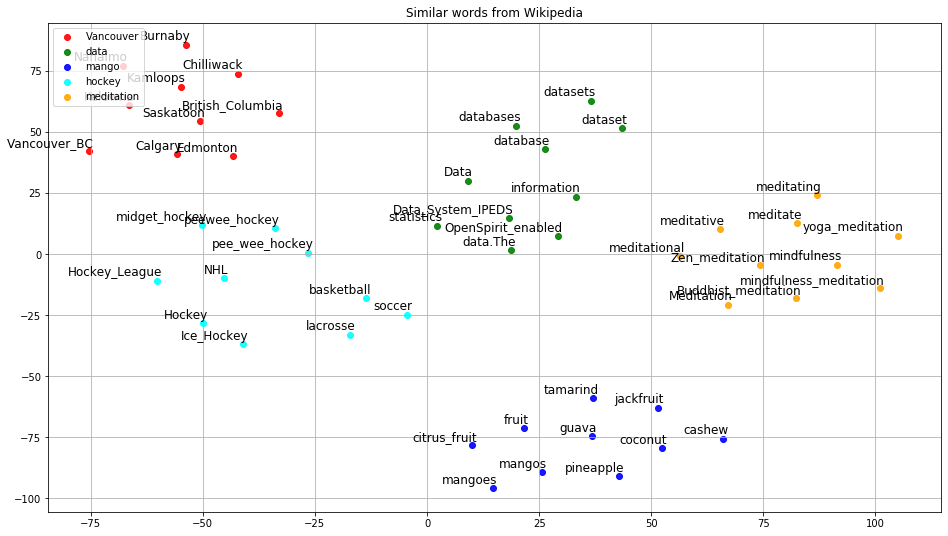

In [13]:
#keys = ['Vancouver', 'data', 'mango', 'hockey', 'meditation']
tsne_plot_similar_words('Similar words from Wikipedia', keys, embeddings_en_2d, word_clusters,  0.9)

### Quality of word vectors

- Extrinsic evaluation 
    * See if they improve accuracy of of downstream applications such as question answering and sentiment analysis. 
- Intrinsic evaluation
    * Compare it to human judgment on the similarity between words.
    * Taking TOEFL multiple-choice vocabulary tests.
        - **Levied**  is closest in meaning to:
          _imposed, believed, requested, correlated_

In [43]:
model.most_similar('levied')

[('levying', 0.7044811844825745),
 ('Dedicating_fines', 0.5996161103248596),
 ('levies', 0.5890565514564514),
 ('imposed', 0.5830395221710205),
 ('fines_levied', 0.5777179002761841),
 ('Levying', 0.5654435753822327),
 ('Osteens_paid', 0.5609164834022522),
 ('levy', 0.5559998154640198),
 ('fines', 0.5462918281555176),
 ('Longe_Velazquez', 0.522169291973114)]

### Using embeddings for text classification

- Assuming that we have reasonable representations of words. 
- How do we represent meaning of paragraphs or documents?
- Two simple approaches
    - Averaging embeddings?
    - Concatenating embeddings?

### Averaging embeddings

<blockquote>
All empty promises!
</blockquote>
    
$(embedding(all) + embedding(empty) + embedding(promise))/3$

In [32]:
# Here is how you upload the pretrained GloVe twitter embeddings. 
# Download [GloVe embeddings for Twitter](http://nlp.stanford.edu/data/glove.twitter.27B.zip). This is a large file (the compressed file is ~1.42 GB ).
# Unzip the downloaded file. For this exercise we'll be using `glove.twitter.27B/glove.twitter.27B.100d.txt`. The file has words and their corresponding pre-trained embeddings.
# Convert the GloVe embeddings to the Word2Vec format using the following command. More details [here](https://www.pydoc.io/pypi/gensim-3.2.0/autoapi/scripts/glove2word2vec/index.html).

# > python -m gensim.scripts.glove2word2vec -i "glove.twitter.27B.100d.txt" -o "glove.twitter.27B.100d.w2v.txt"

# Load the `glove_twitter_model` as follows


glove_twitter_model = KeyedVectors.load_word2vec_format('/Users/kvarada/MDS/2018-19/575/data/glove.twitter.27B/glove.twitter.27B.100d.w2v.txt', 
                                                          binary=False)  # C text format

In [33]:
def get_average_embeddings(text, model = glove_twitter_model):
    """
    Returns the average embedding of the given text
    using the given trained model (e.g., Word2vec, FastText). 
    
    Arguments
    ---------
    text : (str) input text 
    model : (gensim.models) model to use to get embeddings
    
    Returns
    -------
    feat_vect : (numpy.ndarray) the average embedding vector of the given text
    """
    n_features = model.vector_size
    
    stop_words = list(set(stopwords.words('english')))
    punctuation = string.punctuation
    stop_words += list(punctuation)
    stop_words.extend(['``','’', '`','br','"',"”", "''", "'s"])        
        
    preprocessed = []    
    tokenized = word_tokenize(text)
    for token in tokenized:
        token = token.lower()
        if token not in stop_words:
            preprocessed.append(token)

    feat_vect = np.zeros(n_features, dtype='float64')
    #index2word_set = set(model.wv.index2word)    
    nwords = 0 

    for word in preprocessed:
        #if word in index2word_set:
        try: 
            nwords += 1
            feat_vect = np.add(feat_vect, model[word])
        except:
            continue
    if nwords == 0:
        nwords = 1
    feat_vect = np.divide(feat_vect, nwords)     
    return feat_vect

In [34]:
toy_review = 'I loved the movie!'
avg_embedding = get_average_embeddings(toy_review)
avg_embedding

array([ 3.60035002e-01,  5.18444985e-01, -2.39145003e-01, -1.46000013e-02,
       -3.29401998e-01, -3.16575006e-01,  3.07255000e-01,  2.64699906e-02,
        1.30725019e-02, -9.27980007e-02,  1.34200003e-01, -4.45720032e-02,
       -4.00855005e+00,  1.61449999e-01,  3.08024995e-01,  4.08237513e-01,
        1.99725010e-01,  4.36849967e-02, -3.68525486e-01,  8.04770023e-01,
        3.41830015e-01,  3.75235006e-01,  1.66220000e-01, -1.64515004e-02,
        5.06889984e-01,  3.68501246e-03,  1.75049976e-02, -6.24995008e-01,
        3.48306007e-01, -4.60869998e-01, -9.68150031e-02, -3.87620002e-01,
       -1.13109006e-01,  2.02615000e-01, -9.97699946e-02,  4.71134990e-01,
        4.99360010e-01, -6.41520023e-01, -3.90730008e-01,  1.36126999e-01,
       -4.49696001e-01, -7.52635002e-01,  3.04244995e-01, -7.60949850e-02,
        1.04534995e-01,  5.39649474e-01,  1.33495003e-01, -3.06942999e-01,
        2.09695004e-01, -3.11054997e-01, -6.92490011e-01, -1.08889500e-01,
       -5.45754991e-01,  

In [16]:
# Data loading and preprocessing
# Using the Sentiment140 corpus (http://help.sentiment140.com/home), 
# which contains tweets labeled with sentiment associated with a brand, product, or topic. 
# The actual dataset contains 1,600,000 tweets. 
# We will be using a small portion of this corpus. 
# You can experiment with the full corpus if your laptop can handle it. 

tweets_df = pd.read_csv('/Users/kvarada/MDS/2018-19/575/data/training.1600000.processed.noemoticon.csv', 
                        encoding = "ISO-8859-1",
                        names=["label","id", "date", "no_query", "name", "text"])
tweets_df['label'] = tweets_df['label'].map({0: 'neg', 4: 'pos'})

# only consider positive and negative reviews
tweets_pos_neg_df = tweets_df[tweets_df['label'].str.startswith(('pos','neg'))]
tweets_pos_neg_df.head()

,label,id,date,no_query,name,text
0,neg,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,neg,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,neg,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,neg,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,neg,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [17]:
tweets_pos_neg_subset_df = tweets_pos_neg_df.sample(40000)
X = tweets_pos_neg_subset_df['text']
y = tweets_pos_neg_subset_df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 110)

In [21]:
# initialize movie_vector object and then turn movie reviews train data into a vector 
from nltk.corpus import stopwords
import string
stop_words = list(set(stopwords.words('english')))
punctuation = string.punctuation
stop_words += list(punctuation)
stop_words.extend(['``','`','br','"',"”", "''", "'s"])

vec = CountVectorizer(min_df=2, 
                      tokenizer=nltk.word_tokenize,
                      stop_words=stop_words)

X_train_counts = vec.fit_transform(X_train) 

# just use the already-fit vectorizer
X_test_counts = vec.transform(X_test) 

In [24]:
from sklearn.linear_model import LogisticRegression
lr_cv = LogisticRegression(solver='lbfgs', max_iter = 10000)
lr_cv.fit(X_train_counts, y_train);
print('Train error rate: ', 1 - lr_cv.score(X_train_counts, y_train))
print('Test error rate: ', 1 - lr_cv.score(X_test_counts, y_test))

Train error rate:  0.14665625000000004
Test error rate:  0.25612500000000005


In [35]:
X_train_glove = [get_average_embeddings(review, model = glove_twitter_model) for review in X_train]
X_test_glove = [get_average_embeddings(review, model = glove_twitter_model) for review in X_test]

In [38]:
lr_glove = LogisticRegression(solver='lbfgs', max_iter=10000)
lr_glove.fit(X_train_glove, y_train);
print('Train error: ', 1 - lr_glove.score(X_train_glove, y_train))
print('Test Error: ', 1 - lr_glove.score(X_test_glove, y_test))

Train error:  0.25931249999999995
Test Error:  0.25825


### Observations
- Not a big difference in the results compared to the `CountVectorizer` in this particular case 
- Seems like we are not overfitting with the average embedding model. 
- Note that we are using word embeddings trained on a completely different corpus as our features for classification.

### Concatenating embeddings

<blockquote>
All empty promises!
</blockquote>

- $embedding(all)$ $embedding(empty)$ $embedding(promise)$
- Might have to chop some text in order to make fixed-sized vectors to feed into ML algorithms.

## Extensions and more advanced models

- [Include phrases](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)
    * New York : New York Times :: Vancouver : Vancouver Sun?
- Contextual representations of words ([ELMo](https://github.com/allenai/allennlp/blob/master/tutorials/how_to/elmo.md))
    * I went to the **bank** to deposit a cheque. 
    * She loves to walk along the <b>bank</b> of a river, and look into the water.
- [doc2vec](https://radimrehurek.com/gensim/models/doc2vec.html) and [paragraph2vec](https://arxiv.org/abs/1405.4053)
    * Learns fixed-length feature representations from variable-length pieces of texts
- [BERT](https://github.com/google-research/bert)
    * A general-purpose language understanding model


###  Word2Vec beyond text and words

- Word2Vec is not limited to text and words and it has been used in many different domains and for many different applications.
    - Examples
        - [graph2vec](https://github.com/benedekrozemberczki/graph2vec)
        - [node2vec](https://github.com/topics/node2vec)
        - [song2vec](https://github.com/lihenryhfl/song2vec)
        - ...             

### Using Word2Vec for product recommendation

- In the lab you will be using Word2Vec for product recommendation. 
- Word2Vec exploits the sequential nature of text data and assumes that the words in similar contexts tend to be similar or related. 
- We could apply the same intuition to product purchasing behaviour of customers! 
    - If we consider products bought together with each other as contexts of each other, then we can say that the products that occur in similar contexts are related or similar. 
   

### Purchase history example
- Bike light and waterproof pants occur in similar contexts
- How about recommending waterproof pants to Sam and Bike light to Jamie?
<img src="images/customer_purchase_history_example.png" width="600" height="600">
(Credit: https://www.bicycling.com/bikes-gear/g20011461/winter-cycling-gear-0/)

### How to train Word2Vec for this?

- What are words, sentences, and vocabulary?
    - Words $\rightarrow$ products
    - Sentences $\rightarrow$ purchase histories 
    - Vocabulary $\rightarrow$ all unique products

<img src="images/customer_purchase_history_labeled.png" width="800" height="800">
(Credit: https://www.bicycling.com/bikes-gear/g20011461/winter-cycling-gear-0/)

### Training the Word2Vec algorithm for product recommendation 
- The idea is to model similarity/relatedness between products based on the distributional hypothesis; the products that occur in similar contexts tend to be related/similar.  
- Using the Word2Vec algorithm, we learn short and dense representations for all products based on the contexts in which they appear.
- If we have a large dataset, we learn meaningful representations of products.  

### Training Word2Vec for product recommendation 

- To train Word2Vec model we need: 
    - preprocessed corpus
    - embedding dimension
    - window size

### Training Word2Vec for product recommendation: Preprocessed corpus 

- List of lists of purchase histories of customers
- `[Customer2_item33, Customer1_item22, ....]` equivalent to a sentence in a typical Word2Vec model
- `Customer2_item33` and `Customer2_item22` are equivalent to words in a typical Word2Vec model. 
    ```
    [
     [Customer1_item1, Customer1_item2, ....], # purchase history for customer1
     [Customer2_item33, Customer1_item22, ....], # purchase history for customer2
     ...
     [Customer100_item244, Customer1_item1, ....], # purchase history for customer100
     ...
     ]
    ```

### Training Word2Vec for product recommendation: window size, embedding dimensions

- Now that you have input for the Word2Vec algorithm, you can train is by setting the appropriate hyperparameters
    - window size
    - embedding dimensions

### What to do with the trained product embeddings? 

- With the trained model, we can find products similar to the product of interest in the vector space and recommend it to the user.  
- Example: Recommend waterproof pants to Sam and bike light to Jamie.

<img src="images/customer_purchase_history_example.png" width="600" height="600">
(Credit: https://www.bicycling.com/bikes-gear/g20011461/winter-cycling-gear-0/)

## Preprocessing

### Preprocessing 
- Why do we need preprocessing?
    - Text data is unstructured and messy. 
    - We need to "normalize" it before we do anything interesting with it. 
- Example:     
    - **Lemma**: Same stem, same part-of-speech, roughly the same meaning
        - Vancouver's &rarr; Vancouver
        - computers &rarr; computer 
        - rising &rarr; rise, rose, rises    

### Tokenization

- Sentence segmentation
    - Split text into sentences
- Word tokenization 
    - Split sentences into words

### Tokenization: sentence segmentation

<blockquote>
MDS is a Master's program at UBC in British Columbia. MDS teaching team is truly multicultural!! Dr. Beuzen did his Ph.D. in Australia. Dr. Lourenzutti did his in Brazil. Dr. Timbers, Dr. Moosvi, and Dr. Kolhatkar did theirs in Canada. Dr. Gelbart did his PhD in the U.S.
</blockquote>

- How many sentences are there in this text? 

In [57]:
### Let's do sentence segmentation on "."
text = ("MDS is a Master's program at UBC in British Columbia. "
        "MDS teaching team is truly multicultural!! "
         "Dr. Beuzen did his Ph.D. in Australia. "
         "Dr. Lourenzutti did his in Brazil. "
         "Dr. Timbers, Dr. Moosvi, and Dr. Kolhatkar did theirs in Canada. " 
         "Dr. Gelbart did his PhD in the U.S.")

print(text.split('.'))

["MDS is a Master's program at UBC in British Columbia", ' MDS teaching team is truly multicultural!! Dr', ' Beuzen did his Ph', 'D', ' in Australia', ' Dr', ' Lourenzutti did his in Brazil', ' Dr', ' Timbers, Dr', ' Moosvi, and Dr', ' Kolhatkar did theirs in Canada', ' Dr', ' Gelbart did his PhD in the U', 'S', '']


### Sentence segmentation

- In English, period (.) is quite ambiguous. (In Chinese, it is unambiguous.)
    - Abbreviations like Dr., U.S., Inc.  
    - Numbers like 60.44%, 0.98
- ! and ? are relatively ambiguous.
- How about writing regular expressions? 
- A common way is using off-the-shelf models for sentence segmentation. 

In [33]:
### Let's try to do sentence segmentation using nltk
from nltk.tokenize import sent_tokenize
sent_tokenized = sent_tokenize(text)
print(sent_tokenized)

["MDS is a Master's program at UBC in British Columbia.", 'MDS teaching team is truly multicultural!!', 'Dr. Beuzen did his Ph.D. in Australia.', 'Dr. Lourenzutti did his in Brazil.', 'Dr. Timbers, Dr. Moosvi, and Dr. Kolhatkar did theirs in Canada.', 'Dr. Gelbart did his PhD in the U.S.']


### Word tokenization

<blockquote>
MDS is a Master's program at UBC in British Columbia. 
</blockquote>

- How many words are there in this sentence?  
- Is whitespace a sufficient condition for a word boundary

### Word tokenization 

<blockquote>
MDS is a Master's program at UBC in British Columbia. 
</blockquote>

- What's our definition of a word?
    - Should British Columbia be one word or two words? 
    - Should punctuation be considered a separate word?
    - What about the punctuations in `U.S.`?
    - What do we do with words like `Master's`?
- This process of identifying word boundaries is referred to as **tokenization**.
- You can use regex but better to do it with off-the-shelf ML models.  

In [38]:
### Let's do word segmentation on white spaces
print("Splitting on whitespace: ", [sent.split() for sent in sent_tokenized])

### Let's try to do word segmentation using nltk
from nltk.tokenize import word_tokenize
word_tokenized = [word_tokenize(sent) for sent in sent_tokenized]
# This is similar to the input format of word2vec algorithm 
print('\n\n\nTokenized: ', word_tokenized)

Splitting on whitespace:  [['MDS', 'is', 'a', "Master's", 'program', 'at', 'UBC', 'in', 'British', 'Columbia.'], ['MDS', 'teaching', 'team', 'is', 'truly', 'multicultural!!'], ['Dr.', 'Beuzen', 'did', 'his', 'Ph.D.', 'in', 'Australia.'], ['Dr.', 'Lourenzutti', 'did', 'his', 'in', 'Brazil.'], ['Dr.', 'Timbers,', 'Dr.', 'Moosvi,', 'and', 'Dr.', 'Kolhatkar', 'did', 'theirs', 'in', 'Canada.'], ['Dr.', 'Gelbart', 'did', 'his', 'PhD', 'in', 'the', 'U.S.']]



Tokenized:  [['MDS', 'is', 'a', 'Master', "'s", 'program', 'at', 'UBC', 'in', 'British', 'Columbia', '.'], ['MDS', 'teaching', 'team', 'is', 'truly', 'multicultural', '!', '!'], ['Dr.', 'Beuzen', 'did', 'his', 'Ph.D.', 'in', 'Australia', '.'], ['Dr.', 'Lourenzutti', 'did', 'his', 'in', 'Brazil', '.'], ['Dr.', 'Timbers', ',', 'Dr.', 'Moosvi', ',', 'and', 'Dr.', 'Kolhatkar', 'did', 'theirs', 'in', 'Canada', '.'], ['Dr.', 'Gelbart', 'did', 'his', 'PhD', 'in', 'the', 'U.S', '.']]


### Word segmentation 

For some languages you need much more sophisticated tokenizers. 
- For languages such as Chinese, there are no spaces between words.
    - [jieba](https://github.com/fxsjy/jieba) is a popular tokenizer for Chinese. 
- German doesn't separate compound words.
    * Example: _rindfleischetikettierungsüberwachungsaufgabenübertragungsgesetz_
    * (the law for the delegation of monitoring beef labeling)

### Types and tokens
- Usually in NLP, we talk about 
    - **Type** an element in the vocabulary
    - **Token** an instance of that type in running text 

### Exercise for you 
<blockquote>    
UBC is located in the beautiful province of British Columbia. It's very close 
to the U.S. border. You'll get to the USA border in about 45 mins by car.     
</blockquote>  

- Consider the example above. 
    - How many types? (task dependent)
    - How many tokens? 

### Other commonly used preprocessing steps

- Punctuation and stopword removal
- Stemming and lemmatization

### Punctuation and stopword removal

- The most frequently occurring words in English are not very useful in many NLP tasks
    - Example: _the_ , _is_ , _a_ , and punctuation
- Probably not very informative in many tasks 

In [40]:
# Let's use `nltk.stopwords`.  
# Add punctuations to the list. 
stop_words = list(set(stopwords.words('english')))
import string 
punctuation = string.punctuation
stop_words += list(punctuation)
#stop_words.extend(['``','`','br','"',"”", "''", "'s"])
print(stop_words)

['i', 'itself', 've', 'just', "wasn't", 'd', "needn't", 'm', 'when', 'won', 'above', 'more', 'few', "weren't", 'doing', 'off', 'but', "it's", 'this', 'all', 'how', 'for', 'mightn', "aren't", 'because', 'both', 'you', "haven't", 'hasn', 'nor', 'same', 'such', 'he', 'now', 'can', 'why', "shouldn't", 'his', 'where', 'weren', 'until', "mightn't", "won't", 'most', 'was', 'have', 'a', 'are', 'about', 'after', 'o', 'it', 'be', 'from', 'them', 'of', 'aren', 'didn', 'once', 'yours', 'any', 'do', 'an', "hasn't", "you've", 'own', 'him', 'its', "couldn't", 'further', 'which', 'whom', 'couldn', 'does', 'to', 'who', 'my', 'wouldn', "that'll", 'those', 'during', 'am', 'under', "should've", 'into', 'down', 'is', 'through', 'these', 'shouldn', "you're", 'as', 'in', "you'll", 'some', 't', 'll', "don't", 'herself', 'again', 'will', 'our', 'there', "shan't", 'ourselves', "mustn't", 'doesn', "hadn't", 'needn', 'isn', 'her', 'your', "doesn't", "wouldn't", 'theirs', 'been', "she's", "isn't", 'ours', 'wasn', 

In [41]:
### Get rid of stop words
preprocessed = []
for sent in word_tokenized:
    for token in sent:
        token = token.lower()
        if token not in stop_words:
            preprocessed.append(token)
print(preprocessed)

['mds', 'master', "'s", 'program', 'ubc', 'british', 'columbia', 'mds', 'teaching', 'team', 'truly', 'multicultural', 'dr.', 'beuzen', 'ph.d.', 'australia', 'dr.', 'lourenzutti', 'brazil', 'dr.', 'timbers', 'dr.', 'moosvi', 'dr.', 'kolhatkar', 'canada', 'dr.', 'gelbart', 'phd', 'u.s']


### Lemmatization 

- For many NLP tasks (e.g., web search) we want to ignore morphological differences between words
    - Example: If your search term is "studying for ML quiz" you might want to include pages containing "tips to study for an ML quiz" or "here is how I studied for my ML quiz"
- Lemmatization converts inflected forms into the base form. 

In [15]:
# nltk has a lemmatizer 
from nltk.stem import WordNetLemmatizer
lemmatizer= WordNetLemmatizer()
print("Lemma of studying: ", lemmatizer.lemmatize('studying','v'))
print("Lemma of studied: ", lemmatizer.lemmatize('studied','v'))

Lemma of studying:  study
Lemma of studied:  study


### Stemming

- Has a similar purpose but it is a crude chopping of affixes 
    * _automates, automatic, automation_ all reduced to _automat_.
- Usually these reduced forms (stems) are not actual words themselves.  
- A popular stemming algorithm for English is PorterStemmer. 
- Beware that it can be aggressive sometimes.

In [43]:
from nltk.stem.porter import PorterStemmer
text = ("UBC is located in the beautiful province of British Columbia... "
       "It's very close to the U.S. border.")
ps = PorterStemmer()
tokenized = word_tokenize(text)
stemmed = [ps.stem(token) for token in tokenized]
print('Before stemming: ', text)
print('\n\nAfter stemming: ', " ".join(stemmed))

Before stemming:  UBC is located in the beautiful province of British Columbia... It's very close to the U.S. border.


After stemming:  ubc is locat in the beauti provinc of british columbia ... It 's veri close to the u.s. border .


### Other tools for preprocessing 

- We used [Natural Language Processing Toolkit (nltk)](https://www.nltk.org/) above
    - You already have used it in 571 and 573  
- Many available tools    
- [spaCy](https://spacy.io/)

### [spaCy](https://spacy.io/)

- Industrial strength NLP library. 
- Lightweight, fast, and convenient to use. 
- spaCy does many things that we did above in one line of code! 
- Also has [multi-lingual](https://spacy.io/models/xx) support

In [17]:
import spacy

# Load the model
nlp = spacy.load("en_core_web_sm")
text = ("MDS is a Master's program at UBC. "
        "MDS teaching team is truly multicultural. "
         "Dr. Beuzen did his Ph.D. in Australia. "
         "Dr. Lourenzutti did his in Brazil. "
         "Dr. Timbers, Dr. Moosvi, and Dr. Kolhatkar did their's in Canada. " 
         "Dr. Gelbart did his Ph.D. in the U.S.")

doc = nlp(text)

In [18]:
# Accessing tokens
tokens = [token for token in doc]
print('\nTokens: ', tokens)

# Accessing lemma
lemmas = [token.lemma_ for token in doc]
print('\nLemmas: ', lemmas)

# Accessing pos
pos = [token.pos_ for token in doc]
print('\nPOS: ', pos)


Tokens:  [MDS, is, a, Master, 's, program, at, UBC, ., MDS, teaching, team, is, truly, multicultural, ., Dr., Beuzen, did, his, Ph.D., in, Australia, ., Dr., Lourenzutti, did, his, in, Brazil, ., Dr., Timbers, ,, Dr., Moosvi, ,, and, Dr., Kolhatkar, did, their, 's, in, Canada, ., Dr., Gelbart, did, his, Ph.D., in, the, U.S.]

Lemmas:  ['MDS', 'be', 'a', 'Master', "'s", 'program', 'at', 'UBC', '.', 'MDS', 'teaching', 'team', 'be', 'truly', 'multicultural', '.', 'Dr.', 'Beuzen', 'do', '-PRON-', 'ph.d.', 'in', 'Australia', '.', 'Dr.', 'Lourenzutti', 'do', '-PRON-', 'in', 'Brazil', '.', 'Dr.', 'Timbers', ',', 'Dr.', 'Moosvi', ',', 'and', 'Dr.', 'Kolhatkar', 'do', '-PRON-', "'", 'in', 'Canada', '.', 'Dr.', 'Gelbart', 'do', '-PRON-', 'ph.d.', 'in', 'the', 'U.S.']

POS:  ['PROPN', 'AUX', 'DET', 'PROPN', 'PART', 'NOUN', 'ADP', 'PROPN', 'PUNCT', 'PROPN', 'NOUN', 'NOUN', 'AUX', 'ADV', 'ADJ', 'PUNCT', 'PROPN', 'PROPN', 'AUX', 'DET', 'NOUN', 'ADP', 'PROPN', 'PUNCT', 'PROPN', 'PROPN', 'AUX', 'PRON

### Other typical NLP tasks 

- In order to understand text, we usually are interested in extracting information from text.
- Part of speech tagging
    - Assigning part-of-speech tags to all words in a sentence.
- Named entity recognition
    - Labelling named “real-world” objects, like persons, companies or locations.    
- Coreference resolution
    - Deciding whether two strings (e.g., UBC vs University of British Columbia) refer to the same entity
- Dependency parsing
    - Representing grammatical structure of a sentence

In [49]:
doc = nlp("University of British Columbia "
          "is located in the beautiful "
          "province of British Columbia.")
# Text and label of named entity span
print("Named entities:\n", [(ent.text, ent.label_) for ent in doc.ents])
print('\nORG means: ', spacy.explain('ORG'))
print('GPE means: ', spacy.explain('GPE'))

Named entities:
 [('University of British Columbia', 'ORG'), ('British Columbia', 'GPE')]

ORG means:  Companies, agencies, institutions, etc.
GPE means:  Countries, cities, states


In [56]:
# Dependency parsing example. 
from spacy import displacy
doc = nlp("I like cats")
displacy.render(doc, style="dep")

### Many other things possible

- A powerful tool 
- All my Capstone groups last year used this tool. 
- You can build your own rule-based searches. 
- You can also access word vectors using spaCy with bigger models. (Currently we are using `en_core_web_sm` model.)

### Useful links

- [spaCy's Python for data science cheat sheet](http://datacamp-community-prod.s3.amazonaws.com/29aa28bf-570a-4965-8f54-d6a541ae4e06)

- [Regular Expressions, Text Normalization, Edit Distance](https://web.stanford.edu/~jurafsky/slp3/2.pdf)
- [Try preprocessing using unix shell](https://web.stanford.edu/class/cs124/lec/124-2020-UnixForPoets.pdf)
- [Flair](https://github.com/flairNLP/flair) is another library with state-of-the-art NLP tools.  